## E23 - 다음에 볼 영화 예측하기

현 시점에서 고객이 원하는 상품은 무엇일까?  
이를 알 수 있는 단서는 어떻게 구할까?  

Session-Based Recommendation: 세션 데이터를 기반으로 고객이 원하는 상품을 추천하는 방법  
세션은 유저의 브라우저의 쿠키와 연동되고 있으며 브라우저가 종료되기 전까지의 유저의 행동을 담은 시퀀스 데이터  
1. 쿠키, 세션, 캐시는?  
https://www.youtube.com/watch?v=OpoVuwxGRDI&ab_channel=%EC%96%84%ED%8C%8D%ED%95%9C%EC%BD%94%EB%94%A9%EC%82%AC%EC%A0%84  
2. 쿠키, 세션?  
https://medium.com/@chrisjune_13837/web-%EC%BF%A0%ED%82%A4-%EC%84%B8%EC%85%98%EC%9D%B4%EB%9E%80-aa6bcb327582  

919411 Session의 유저가 8분여에 걸쳐 4개의 아이템(214853420 214850942 214829878 214853420)을 본 상황일 때  
유저가 214853420 아이템을 보았을 때 214850942을 추천하고 이어서 214850942을 보았을 때 214829878을 추천하고 싶다.  

mkdir -p ~/aiffel/yoochoose-data  
cd ~/aiffel  
wget https://aiffelstaticprd.blob.core.windows.net/media/documents/yoochoose-data.7z  
sudo apt install p7zip-full  
7z x yoochoose-data.7z -oyoochoose-data  

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

데이터 설명을 보면  
1. 유저에 대한 정보를 전혀 알 수 없다.(성별, 나이, 정소, 등등)
2. 아이템에 대한 정보도 알 수 없다.

유저의 정보를 알 수 있는 경우는 보통 Sequential Recommendation이라고도 한다.  
유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야를 Context-Aware라고 한다.  

E-Commerce데이터의 경우 다음과 같은 특징을 가진다.
1. 비로그인 상태로 탐색하는 유저가 많다.
2. 로그인 상태로 탐색하여도 접속할 때마다 탐색 의도가 뚜렷하지 않다.

### Data Preprocess

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
# pathlib 라이브러리: 파일위치 찾기, 파일 입출력을 관리할 수 있다.
# https://brownbears.tistory.com/415#:~:text=pathlib%20%EC%84%A4%EB%AA%85,%EB%A1%9C%20%EB%8B%A4%EB%A3%A8%EC%9E%90%EB%8A%94%20%EA%B2%83%EC%9E%85%EB%8B%88%EB%8B%A4.&amp;text=pathlib%EC%9D%80%20%EC%8A%AC%EB%9E%98%EC%8B%9C(/)%EA%B0%80,%EC%A7%81%EA%B4%80%EC%A0%81%EC%9C%BC%EB%A1%9C%20%EC%9D%B4%ED%95%B4%ED%95%A0%20%EC%88%98%20%EC%9E%88%EC%8A%B5%EB%8B%88%EB%8B%A4.
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/home/aiffel0042/aiffel/yoochoose-data/yoochoose-clicks.dat')

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [5]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


In [6]:
# 유저수와 아이템 수 확인하기

data['SessionId'].nunique(), data['ItemId'].nunique()

#한 명의 유저가 여러 개의 세션을 만들 수도 있기 때문에 저 숫자는 유저의 수가 아니다.

(9249729, 52739)

In [7]:
# 각 세션이 기지고 있는 클릭 데이터의 수 알아보기

session_length = data.groupby('SessionId').size()
session_length

# 하나의 세션이 동일한 사용자일 수도 있고 아닐 수도 있지만 그 세션동안 몇 번의 액션이 있었는지 알 수 있다.

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [9]:
session_length.min(), session_length.max()

(1, 200)

In [10]:
session_length.quantile(0.999)

41.0

In [11]:
# 99.9%의 세션이 41.0인데 max길이가 200인 세션이 있다.

long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


매우 짧은 간격으로 1시간 30분 가량 클릭이 되고 있다.  
유저들마다 행동 패턴이 다양하므로 데이터 전처리시 어떻게 해야할 지 선택해야 한다.  
e.g.) 음약 데이터의 경우 하루종일 랜덤재생할 경우 이 데이터는 어떻게 처리할지?  
e.g.) 어떤 상품의 경우 1분 이내에 20명이 10점을 주고 나갈 경우, 혹시 조작?  
세션을 어떻게 처리할 지 그래프로 확인해보자


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

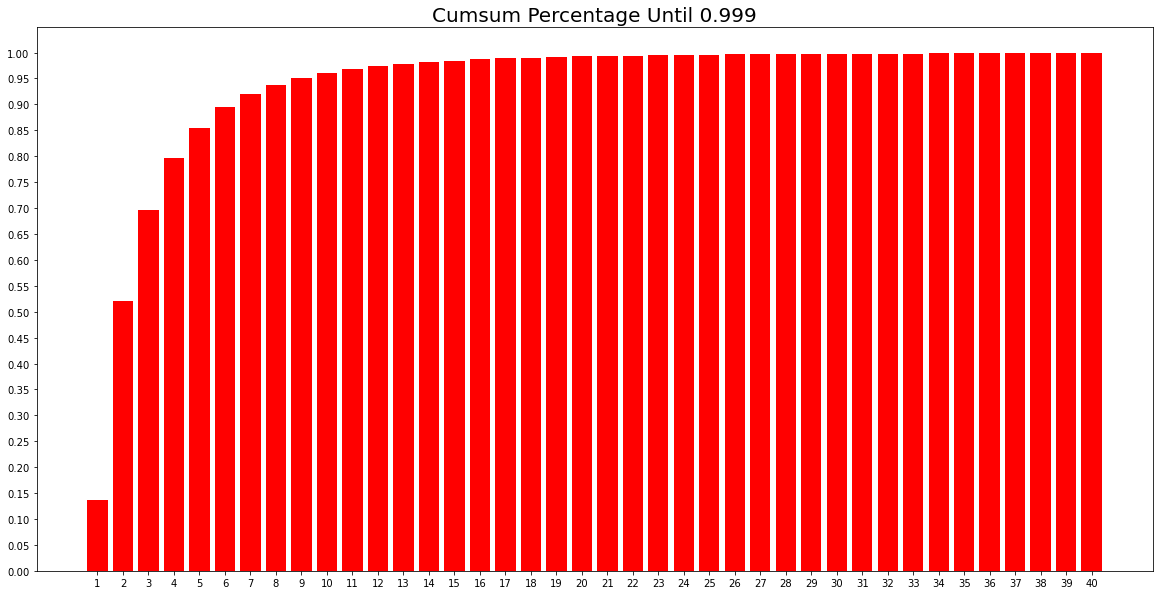

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

Session Time  
세션이 생성된 날짜 뿐 아니라 접속한 시간대, 요일, 계절 등을 알 수 있다.

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


In [15]:
type(latest)

# Time은 Timestamp 객체이므로 int 객체와 사칙연산이 안 된다.
# 날짜끼리 차이를 구하고 싶을 떄는 timedelta를 사용한다.

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


세션 길이가 1인 세션도 있다. 다음 상품을 예측할 수 없다.  
추천 시스템이 목적이므로 1인 세션은 제거한다.

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


In [19]:
# Train/Valid/Test split

test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

소비 트렌드는 시간에 따라 다르므로 1달 전의 모델이 현재는 맞지 않을 수 있다.   
그래서 train/valid/test을 기간에 따라 나누기도 한다.  
이번에는 마지막 1일 기간 동안을 test로 하고
2일전부터 1일 전까지를 valid set으로 나누겠다.

In [25]:
final_time = data['Time'].max()
session_last_time = data.groupby('SessionId')['Time'].max()
session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(1)].index
session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(1)].index
session_in_test

Int64Index([11255568, 11255571, 11255572, 11255599, 11255661, 11255731,
            11255754, 11255758, 11255771, 11255787,
            ...
            11561946, 11561949, 11561964, 11561991, 11562008, 11562034,
            11562079, 11562117, 11562118, 11562142],
           dtype='int64', name='SessionId', length=15289)

In [26]:
session_in_train

Int64Index([ 9194111,  9194123,  9194124,  9194127,  9194128,  9194129,
             9194132,  9194133,  9194146,  9194147,
            ...
            11562144, 11562146, 11562147, 11562148, 11562151, 11562152,
            11562153, 11562156, 11562157, 11562158],
           dtype='int64', name='SessionId', length=1255783)

In [20]:


before_date = data[data['SessionId'].isin(session_in_train)]
after_date = data[data['SessionId'].isin(session_in_test)]

In [22]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [23]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [24]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [25]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [27]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### GRU4REC
Session-Parallel Mini-Batches  
긴 세션과 짧은 세션을 같이 mini-batch를 구성하면 긴 세션의 연산이 끝날 때까지 짧은 세션들은 기다려야 한다.  
이를 해결하기 위해 Session을 병렬로 처리하는 방법을 제시한다.  
mini-batch의 shape는 (3,1,1)  
sampling on the output: negative sampling와 같은 개념. item수가 많기 떄문에 모든 아이템을 비교하지 않고 인기도를 고려하여 sampling한다.  
ranking loss: 여러 아이템 중에서 관련도 순으로 랭킹을 매겨 높은 랭킹의 아이템을 추천해주는 task  
classification: 여러 아이템 중 다음 아이템이 무엇인지 classification task
### Data Pipeline

In [28]:
# Session Dataset
# 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스
# click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있다.
# session_idx 변수는 각 세션을 인덱싱한 np.array

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [31]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [32]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

#### session dataloader

In [33]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [35]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [36]:
iter_ex = iter(tr_data_loader)

In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


### Modeling
#### Evaluation Metric
모델의 성능 지표로 Precision, Recall이 있다.  
Session_Based Recommendation task에서는 모델이 k개의 아이템을 제시했을 때,  
유저가 클릭/구매한 n개의 아이템이 많아야 좋다.  
이를 Recall을 확장한 recall@k, precision을 확장한 Mean Average Precision@k을 사용한다.  
추천에서는 몇 번째로 맞추느냐도 중요하다. 순서에 민감한 지표로는 MRR, NDCG 사용한다.  
MRR은 정답 아이템이 나온 순번의 역수 값이다. 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아진다.  
https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832

In [49]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [51]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [52]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [53]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


#### Model Training

In [54]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [ ]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.455308
	 - MRR@20    epoch 1: 0.170300



Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.600442
	 - MRR@20    epoch 2: 0.244795



Evaluation:  23%|██▎       | 5/22 [00:17<00:57,  3.39s/it]

#### Inference

In [ ]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)